# Mava Quickstart Notebook



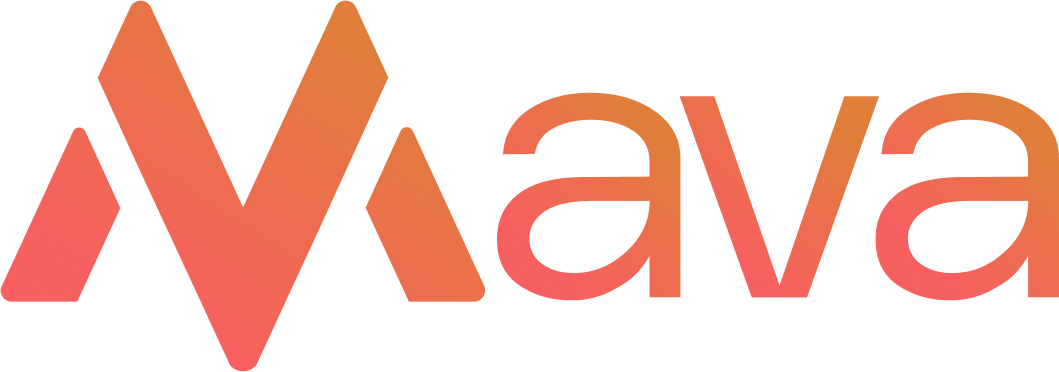

### This notebook offers a simple introduction to [Mava](https://github.com/instadeepai/Mava) by showing how to build and train a multi-agent PPO (MAPPO) system on the RobotWarehouse environment from [Jumanji](https://github.com/instadeepai/jumanji). Mava follows the design philosophy of [CleanRL](https://github.com/vwxyzjn/cleanrl) allowing for easy code readability and reuse, and is built on top of code from [PureJaxRL](https://github.com/luchris429/purejaxrl), extending it to provide end-to-end JAX-based multi-agent algorithms.

<a href="https://colab.research.google.com/github/instadeepai/Mava/blob/fix/quickstart-notebook/examples/Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Requirements

We start by installing and importing the necessary packages.

In [1]:
%%capture
# @title Install required packages
! pip install git+https://github.com/instadeepai/mava.git@fix/quickstart-notebook

In [2]:
# @title Import required packages.

import time
from typing import Any, Sequence, Tuple

import chex
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import tree

# Env requirements
import jumanji

# Plot requirements
import matplotlib.pyplot as plt
import numpy as np
import optax
import tensorflow_probability.substrates.jax.distributions as tfd
from colorama import Fore, Style
from flax.core.frozen_dict import FrozenDict
from flax.linen.initializers import orthogonal
from IPython.display import clear_output
from omegaconf import DictConfig, OmegaConf
from optax._src.base import OptState

# Mava Helpful functions and types
from mava.networks.distributions import IdentityTransformation
from mava.evaluator import get_eval_fn, make_ff_eval_act_fn
from mava.systems.ppo.types import LearnerState, OptStates, Params, PPOTransition
from mava.types import (
    ActorApply,
    CriticApply,
    ExperimentOutput,
    LearnerFn,
    Observation,
    ObservationGlobalState,
)
from mava.utils.jax_utils import (
    merge_leading_dims,
    unreplicate_batch_dim,
    unreplicate_n_dims,
)
from mava.utils.training import make_learning_rate
from mava.wrappers import (
    AgentIDWrapper,
    RwareWrapper,
)
from jumanji.environments.routing.robot_warehouse.generator import (
    RandomGenerator as RwareRandomGenerator,
)
from mava.utils import make_env as environments

%matplotlib inline
import seaborn as sns

sns.set()
sns.set_style("white")
sns.color_palette("colorblind")

import warnings

warnings.filterwarnings("ignore")

# Trainer
This section encompasses the foundational methods required to set up the training process for MAPPO.


### Network

Initially, we start by constructing the Actor and Critic networks using components from the Flax library.

* The `Actor()` network takes an observation as input and produces logits representing the probabilities of different actions. The shapes within the network are determined dynamically based on the number of agents, the observation, and the batch size.
* The `Critic()` network takes the global state as input and produces the estimated value of the state. Similar to the Actor network, the shapes within the network are handled implicitly by Flax.

In [3]:
class Actor(nn.Module):
    """Actor Network."""

    action_dim: Sequence[int]

    @nn.compact
    def __call__(self, observation: Observation) -> tfd.TransformedDistribution:
        """Forward pass."""
        x = observation.agents_view

        actor_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)))(x)
        actor_output = nn.relu(actor_output)
        actor_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)))(actor_output)
        actor_output = nn.relu(actor_output)
        actor_output = nn.Dense(self.action_dim, kernel_init=orthogonal(0.01))(actor_output)

        masked_logits = jnp.where(
            observation.action_mask,
            actor_output,
            jnp.finfo(jnp.float32).min,
        )

        return IdentityTransformation(distribution=tfd.Categorical(logits=masked_logits))


class Critic(nn.Module):
    """Critic Network."""

    @nn.compact
    def __call__(self, observation: ObservationGlobalState) -> chex.Array:
        """Forward pass."""
        critic_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)))(observation.global_state)
        critic_output = nn.relu(critic_output)
        critic_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)))(critic_output)
        critic_output = nn.relu(critic_output)
        critic_output = nn.Dense(1, kernel_init=orthogonal(1.0))(critic_output)

        return jnp.squeeze(critic_output, axis=-1)

### Learner Function
The `get_learner_fn` function returns a function which produces an `ExperimentOutput`, encapsulating the updated learner state, episode information, and loss metrics.

In [4]:
def get_learner_fn(
    env: jumanji.Environment,
    apply_fns: Tuple[ActorApply, CriticApply],
    update_fns: Tuple[optax.TransformUpdateFn, optax.TransformUpdateFn],
    config: DictConfig,
) -> LearnerFn[LearnerState]:
    """Get the learner function."""
    # Unpack apply and update functions.
    actor_apply_fn, critic_apply_fn = apply_fns
    actor_update_fn, critic_update_fn = update_fns

    def _update_step(learner_state: LearnerState, _: Any) -> Tuple[LearnerState, Tuple]:
        """A single update of the network.

        This function steps the environment and records the trajectory batch for
        training. It then calculates advantages and targets based on the recorded
        trajectory and updates the actor and critic networks based on the calculated
        losses.

        Args:
        ----
            learner_state (NamedTuple):
                - params (Params): The current model parameters.
                - opt_states (OptStates): The current optimizer states.
                - key (PRNGKey): The random number generator state.
                - env_state (State): The environment state.
                - last_timestep (TimeStep): The last timestep in the current trajectory.
            _ (Any): The current metrics info.

        """

        def _env_step(learner_state: LearnerState, _: Any) -> Tuple[LearnerState, PPOTransition]:
            """Step the environment."""
            params, opt_states, key, env_state, last_timestep = learner_state

            # SELECT ACTION
            key, policy_key = jax.random.split(key)
            actor_policy = actor_apply_fn(params.actor_params, last_timestep.observation)
            value = critic_apply_fn(params.critic_params, last_timestep.observation)
            action = actor_policy.sample(seed=policy_key)
            log_prob = actor_policy.log_prob(action)

            # STEP ENVIRONMENT
            env_state, timestep = jax.vmap(env.step, in_axes=(0, 0))(env_state, action)

            # LOG EPISODE METRICS
            done = tree.map(
                lambda x: jnp.repeat(x, config.system.num_agents).reshape(config.arch.num_envs, -1),
                timestep.last(),
            )
            info = timestep.extras["episode_metrics"]

            transition = PPOTransition(
                done,
                action,
                value,
                timestep.reward,
                log_prob,
                last_timestep.observation,
                info,
            )
            learner_state = LearnerState(params, opt_states, key, env_state, timestep)
            return learner_state, transition

        # STEP ENVIRONMENT FOR ROLLOUT LENGTH
        learner_state, traj_batch = jax.lax.scan(
            _env_step, learner_state, None, config.system.rollout_length
        )

        # CALCULATE ADVANTAGE
        params, opt_states, key, env_state, last_timestep = learner_state
        last_val = critic_apply_fn(params.critic_params, last_timestep.observation)

        def _calculate_gae(
            traj_batch: PPOTransition, last_val: chex.Array
        ) -> Tuple[chex.Array, chex.Array]:
            """Calculate the GAE."""

            def _get_advantages(gae_and_next_value: Tuple, transition: PPOTransition) -> Tuple:
                """Calculate the GAE for a single transition."""
                gae, next_value = gae_and_next_value
                done, value, reward = (
                    transition.done,
                    transition.value,
                    transition.reward,
                )
                gamma = config.system.gamma
                delta = reward + gamma * next_value * (1 - done) - value
                gae = delta + gamma * config.system.gae_lambda * (1 - done) * gae
                return (gae, value), gae

            _, advantages = jax.lax.scan(
                _get_advantages,
                (jnp.zeros_like(last_val), last_val),
                traj_batch,
                reverse=True,
                unroll=16,
            )
            return advantages, advantages + traj_batch.value

        advantages, targets = _calculate_gae(traj_batch, last_val)

        def _update_epoch(update_state: Tuple, _: Any) -> Tuple:
            """Update the network for a single epoch."""

            def _update_minibatch(train_state: Tuple, batch_info: Tuple) -> Tuple:
                """Update the network for a single minibatch."""
                # UNPACK TRAIN STATE AND BATCH INFO
                params, opt_states, key = train_state
                traj_batch, advantages, targets = batch_info

                def _actor_loss_fn(
                    actor_params: FrozenDict,
                    actor_opt_state: OptState,
                    traj_batch: PPOTransition,
                    gae: chex.Array,
                    key: chex.PRNGKey,
                ) -> Tuple:
                    """Calculate the actor loss."""
                    # RERUN NETWORK
                    actor_policy = actor_apply_fn(actor_params, traj_batch.obs)
                    log_prob = actor_policy.log_prob(traj_batch.action)

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - traj_batch.log_prob)
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = (
                        jnp.clip(
                            ratio,
                            1.0 - config.system.clip_eps,
                            1.0 + config.system.clip_eps,
                        )
                        * gae
                    )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    # The seed will be used in the TanhTransformedDistribution:
                    entropy = actor_policy.entropy(seed=key).mean()

                    total_loss_actor = loss_actor - config.system.ent_coef * entropy
                    return total_loss_actor, (loss_actor, entropy)

                def _critic_loss_fn(
                    critic_params: FrozenDict,
                    critic_opt_state: OptState,
                    traj_batch: PPOTransition,
                    targets: chex.Array,
                ) -> Tuple:
                    """Calculate the critic loss."""
                    # RERUN NETWORK
                    value = critic_apply_fn(critic_params, traj_batch.obs)

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = traj_batch.value + (value - traj_batch.value).clip(
                        -config.system.clip_eps, config.system.clip_eps
                    )
                    value_losses = jnp.square(value - targets)
                    value_losses_clipped = jnp.square(value_pred_clipped - targets)
                    value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()

                    critic_total_loss = config.system.vf_coef * value_loss
                    return critic_total_loss, (value_loss)

                # CALCULATE ACTOR LOSS
                key, entropy_key = jax.random.split(key)
                actor_grad_fn = jax.value_and_grad(_actor_loss_fn, has_aux=True)
                actor_loss_info, actor_grads = actor_grad_fn(
                    params.actor_params,
                    opt_states.actor_opt_state,
                    traj_batch,
                    advantages,
                    entropy_key,
                )

                # CALCULATE CRITIC LOSS
                critic_grad_fn = jax.value_and_grad(_critic_loss_fn, has_aux=True)
                critic_loss_info, critic_grads = critic_grad_fn(
                    params.critic_params,
                    opt_states.critic_opt_state,
                    traj_batch,
                    targets,
                )

                # Compute the parallel mean (pmean) over the batch.
                # This calculation is inspired by the Anakin architecture demo notebook.
                # available at https://tinyurl.com/26tdzs5x
                # This pmean could be a regular mean as the batch axis is on the same device.
                actor_grads, actor_loss_info = jax.lax.pmean(
                    (actor_grads, actor_loss_info), axis_name="batch"
                )
                # pmean over devices.
                actor_grads, actor_loss_info = jax.lax.pmean(
                    (actor_grads, actor_loss_info), axis_name="device"
                )

                critic_grads, critic_loss_info = jax.lax.pmean(
                    (critic_grads, critic_loss_info), axis_name="batch"
                )
                # pmean over devices.
                critic_grads, critic_loss_info = jax.lax.pmean(
                    (critic_grads, critic_loss_info), axis_name="device"
                )

                # UPDATE ACTOR PARAMS AND OPTIMISER STATE
                actor_updates, actor_new_opt_state = actor_update_fn(
                    actor_grads, opt_states.actor_opt_state
                )
                actor_new_params = optax.apply_updates(params.actor_params, actor_updates)

                # UPDATE CRITIC PARAMS AND OPTIMISER STATE
                critic_updates, critic_new_opt_state = critic_update_fn(
                    critic_grads, opt_states.critic_opt_state
                )
                critic_new_params = optax.apply_updates(params.critic_params, critic_updates)

                new_params = Params(actor_new_params, critic_new_params)
                new_opt_state = OptStates(actor_new_opt_state, critic_new_opt_state)

                # PACK LOSS INFO
                total_loss = actor_loss_info[0] + critic_loss_info[0]
                value_loss = critic_loss_info[1]
                actor_loss = actor_loss_info[1][0]
                entropy = actor_loss_info[1][1]
                loss_info = {
                    "total_loss": total_loss,
                    "value_loss": value_loss,
                    "actor_loss": actor_loss,
                    "entropy": entropy,
                }
                return (new_params, new_opt_state, entropy_key), loss_info

            params, opt_states, traj_batch, advantages, targets, key = update_state
            key, shuffle_key, entropy_key = jax.random.split(key, 3)

            # SHUFFLE MINIBATCHES
            batch_size = config.system.rollout_length * config.arch.num_envs
            permutation = jax.random.permutation(shuffle_key, batch_size)
            batch = (traj_batch, advantages, targets)
            batch = tree.map(lambda x: merge_leading_dims(x, 2), batch)
            shuffled_batch = tree.map(lambda x: jnp.take(x, permutation, axis=0), batch)
            minibatches = tree.map(
                lambda x: jnp.reshape(x, [config.system.num_minibatches, -1] + list(x.shape[1:])),
                shuffled_batch,
            )

            # UPDATE MINIBATCHES
            (params, opt_states, entropy_key), loss_info = jax.lax.scan(
                _update_minibatch, (params, opt_states, entropy_key), minibatches
            )

            update_state = (params, opt_states, traj_batch, advantages, targets, key)
            return update_state, loss_info

        update_state = (params, opt_states, traj_batch, advantages, targets, key)

        # UPDATE EPOCHS
        update_state, loss_info = jax.lax.scan(
            _update_epoch, update_state, None, config.system.ppo_epochs
        )

        params, opt_states, traj_batch, advantages, targets, key = update_state
        learner_state = LearnerState(params, opt_states, key, env_state, last_timestep)
        metric = traj_batch.info
        return learner_state, (metric, loss_info)

    def learner_fn(learner_state: LearnerState) -> ExperimentOutput[LearnerState]:
        """Learner function.

        This function represents the learner, it updates the network parameters
        by iteratively applying the `_update_step` function for a fixed number of
        updates. The `_update_step` function is vectorized over a batch of inputs.

        Args:
        ----
            learner_state (NamedTuple):
                - params (Params): The initial model parameters.
                - opt_states (OptStates): The initial optimizer states.
                - key (chex.PRNGKey): The random number generator state.
                - env_state (LogEnvState): The environment state.
                - timesteps (TimeStep): The initial timestep in the initial trajectory.

        """
        batched_update_step = jax.vmap(_update_step, in_axes=(0, None), axis_name="batch")

        learner_state, (episode_info, loss_info) = jax.lax.scan(
            batched_update_step, learner_state, None, config.system.num_updates_per_eval
        )
        return ExperimentOutput(
            learner_state=learner_state,
            episode_metrics=episode_info,
            train_metrics=loss_info,
        )

    return learner_fn

### Learner Setup
The learner setup initialises components for training: the learner function, actor and critic networks and optimizers and environment states. It creates a function for learning, employs parallel processing over the cores for efficiency, and sets up initial states.

In [5]:
def learner_setup(
    env: jumanji.Environment, keys: chex.Array, config: DictConfig
) -> Tuple[LearnerFn[LearnerState], Actor, LearnerState]:
    """Initialise learner_fn, network, optimiser, environment and states."""
    # Get available TPU cores.
    n_devices = len(jax.devices())

    # Get number of agents.
    config.system.num_agents = env.num_agents

    # PRNG keys.
    key, actor_net_key, critic_net_key = keys

    # Define network and optimiser.
    actor_network = Actor(env.action_dim)
    critic_network = Critic()

    actor_lr = make_learning_rate(config.system.actor_lr, config)
    critic_lr = make_learning_rate(config.system.critic_lr, config)

    actor_optim = optax.chain(
        optax.clip_by_global_norm(config.system.max_grad_norm),
        optax.adam(actor_lr, eps=1e-5),
    )
    critic_optim = optax.chain(
        optax.clip_by_global_norm(config.system.max_grad_norm),
        optax.adam(critic_lr, eps=1e-5),
    )

    # Initialise observation with obs of all agents.
    obs = env.observation_spec().generate_value()
    init_x = tree.map(lambda x: x[jnp.newaxis, ...], obs)

    # Initialise actor params and optimiser state.
    actor_params = actor_network.init(actor_net_key, init_x)
    actor_opt_state = actor_optim.init(actor_params)

    # Initialise critic params and optimiser state.
    critic_params = critic_network.init(critic_net_key, init_x)
    critic_opt_state = critic_optim.init(critic_params)

    # Pack params.
    params = Params(actor_params, critic_params)

    # Pack apply and update functions.
    apply_fns = (actor_network.apply, critic_network.apply)
    update_fns = (actor_optim.update, critic_optim.update)

    # Get batched iterated update and replicate it to pmap it over cores.
    learn = get_learner_fn(env, apply_fns, update_fns, config)
    learn = jax.pmap(learn, axis_name="device")

    # Initialise environment states and timesteps: across devices and batches.
    key, *env_keys = jax.random.split(
        key, n_devices * config.system.update_batch_size * config.arch.num_envs + 1
    )
    env_states, timesteps = jax.vmap(env.reset, in_axes=(0))(
        jnp.stack(env_keys),
    )
    reshape_states = lambda x: x.reshape(
        (n_devices, config.system.update_batch_size, config.arch.num_envs) + x.shape[1:]
    )
    # (devices, update batch size, num_envs, ...)
    env_states = jax.tree.map(reshape_states, env_states)
    timesteps = jax.tree.map(reshape_states, timesteps)

    # Define params to be replicated across devices and batches.
    key, step_keys = jax.random.split(key)
    opt_states = OptStates(actor_opt_state, critic_opt_state)
    replicate_learner = (params, opt_states, step_keys)

    # Duplicate learner for update_batch_size.
    broadcast = lambda x: jnp.broadcast_to(x, (config.system.update_batch_size,) + x.shape)
    replicate_learner = jax.tree.map(broadcast, replicate_learner)

    # Duplicate learner across devices.
    replicate_learner = flax.jax_utils.replicate(replicate_learner, devices=jax.devices())

    # Initialise learner state.
    params, opt_states, step_keys = replicate_learner
    init_learner_state = LearnerState(params, opt_states, step_keys, env_states, timesteps)

    return learn, actor_network, init_learner_state

# Rendering and logging tools

### Rendering
The `render_one_episode` function simulates and visualises one episode from rolling out a trained MAPPO model that will be passed to the function using `actors_params`.

In [6]:
def render_one_episode(config, params, max_steps=100) -> None:
    """Rollout episodes of a trained MAPPO policy."""
    # Create envs
    env_config = {**config.env.kwargs, **config.env.scenario.env_kwargs}
    generator = RwareRandomGenerator(**config.env.scenario.task_config)
    env = jumanji.make(config.env.scenario.name, generator=generator, **env_config)
    env = RwareWrapper(env)
    if config.system.add_agent_id:
        env = AgentIDWrapper(env)

    # Create actor networks (We only care about the policy during rendering)
    actor_network = Actor(env.action_dim)
    apply_fn = actor_network.apply

    reset_fn = jax.jit(env.reset)
    step_fn = jax.jit(env.step)
    key = jax.random.PRNGKey(config.system.seed)
    key, reset_key = jax.random.split(key)
    state, timestep = reset_fn(reset_key)

    states = [state]
    episode_return = 0
    episode_length = 0
    while not timestep.last():
        key, action_key = jax.random.split(key)
        pi = apply_fn(params, timestep.observation)

        if config["arch"]["evaluation_greedy"]:
            action = pi.mode()
        else:
            action = pi.sample(seed=action_key)
        state, timestep = step_fn(state, action)
        states.append(state)
        episode_return += jnp.mean(timestep.reward)
        episode_length += 1

    # Print out the results of the episode
    print(f"{Fore.CYAN}{Style.BRIGHT}EPISODE RETURN: {episode_return}{Style.RESET_ALL}")
    print(f"{Fore.CYAN}{Style.BRIGHT}EPISODE LENGTH:{episode_length}{Style.RESET_ALL}")

    # Limit the number of steps to record to the maximum number of steps
    steps = min([max_steps, len(states) - 1])
    states = states[:steps]

    # Render the episode
    env.animate(states=states, interval=100, save_path="./rware.gif")

### Logging:
The `plot_performance` function visualises the performance of the algorithm. This plot will be refreshed each time evaluation interval happens!

In [7]:
def plot_performance(mean_episode_return, ep_returns, start_time):
    plt.figure(figsize=(8, 4))
    clear_output(wait=True)

    # Plot the data
    ep_returns.append(mean_episode_return)
    plt.plot(
        np.linspace(0, (time.time() - start_time) / 60.0, len(list(ep_returns))), list(ep_returns)
    )
    plt.xlabel("Run Time [Minutes]")
    plt.ylabel("Episode Return")
    plt.title("Robotic Warehouse with 4 Agents")

    # Show the plot
    plt.show()
    return ep_returns

# Experiment Setup

The experiment setup includes: defining the hyperparameters, creating environments, setting up the learner and evaluator, and initialising some variables for plotting and logging purposes.


#### Config

We start the experiment setup by defining the config dictionary that represents a set of the various hyperparameters for the experiment.

In addition to the typical hyperparameters used in MARL algorithms, we define below a few variables relevant to our implementation:

`num_updates`: The number of gradient updates to perform during the training.

`num_envs`:  Number of vectorised environments per device. For instance, if set to 512, it implies that 512 environments will be running in parallel at the same time on a given process.

`num_evaluation` and `num_eval_episodes`: The `num_evaluation` parameter specifies how many evenly spaced evaluation steps will occur during training, while the `num_eval_episode` specifies how many episodes will be rolled out at each evaluation step.

In [8]:
config = {
    "system": {
        "actor_lr": 2.5e-4,
        "critic_lr": 2.5e-4,
        "update_batch_size": 2,
        "rollout_length": 128,
        "num_updates": 400,
        "ppo_epochs": 16,
        "num_minibatches": 32,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_eps": 0.2,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "add_agent_id": True,
        "decay_learning_rates": False,
        "seed": 42,
    },
    "arch": {
        "num_envs": 512,
        "num_eval_episodes": 32,
        "num_evaluation": 50,
        "evaluation_greedy": False,
        "num_absolute_metric_eval_episodes": 32,
    },
    "env": {
        "env_name": "RobotWarehouse",
        "eval_metric": "episode_return",
        "implicit_agent_id": False,
        "log_win_rate": False,
        "kwargs": {"time_limit": 500},
        "scenario": {
            "name": "RobotWarehouse-v0",
            "task_name": "tiny-4ag-easy",
            "task_config": {
                "column_height": 8,
                "shelf_rows": 1,
                "shelf_columns": 3,
                "num_agents": 4,
                "sensor_range": 1,
                "request_queue_size": 8,
            },
            "env_kwargs": {},
        },
    },
}
# Convert the Python dictionary to a DictConfig
config: DictConfig = OmegaConf.create(config)

#### Create the Training and Evaluation environments

We use Mava's utility functions to create our environments for us. These environments will have a seuqnece of wrappers applied to them that will add agent identifiers and will log any relevant metrics. Since MAPPO has a centralised critic, we will also need the environment to return the true underlying environment state along with the individual agent observations. This is why we pass in `add_global_state=True`. FOr more information on all the wrappers that are applied, please see [here](https://github.com/instadeepai/Mava/blob/8b758133056e86303ab1acbe5aa2ade02e0f6e70/mava/utils/make_env.py#L86).

In [9]:
env, eval_env = environments.make(config, add_global_state=True)

#### Additional variable definitions


In this section of the code, the total number of timesteps for the experiment is calculated, followed by the partitioning of the training timesteps into distinct intervals determined by the value of `num_evaluation`.

**Calculating Total Timesteps:**

To calculate the total timesteps, the following formula is used:
```
total_timesteps = n_devices
* num_updates
* rollout_length
* update_batch_size
* num_envs
```
- `n_devices` represents the number of JAX devices available, which is essential for parallel computation.
- `num_updates` is the number of vectorised gradient updates to be be performed on each device.
- `rollout_length` is the number of timesteps in each rollout.
- `update_batch_size` is the batch size used for each update.
- `num_envs` is the number of parallel environments used for data collection.

This computation yields the total count of timesteps that will be carried out throughout the complete training procedure. Consequently, the number of timesteps within each training interval is established as ```total_timesteps/num_evaluation```





In [10]:
def compute_total_timesteps(config: DictConfig):
    # Calculate total timesteps.
    n_devices = len(jax.devices())
    config["system"]["num_updates_per_eval"] = (
        config["system"]["num_updates"] // config["arch"]["num_evaluation"]
    )
    steps_per_rollout = (
        n_devices
        * config["system"]["num_updates_per_eval"]
        * config["system"]["rollout_length"]
        * config["system"]["update_batch_size"]
        * config["arch"]["num_envs"]
    )

    return steps_per_rollout, config

#### The Learner and Evaluator Setup



In [11]:
# PRNG keys.
key, key_e, actor_net_key, critic_net_key = jax.random.split(
    jax.random.PRNGKey(config.system.seed), num=4
)

# Setup learner.
learn, actor_network, learner_state = learner_setup(
    env, (key, actor_net_key, critic_net_key), config
)

eval_act_fn = make_ff_eval_act_fn(actor_network.apply, config)

# Setup evaluator.
evaluator = get_eval_fn(eval_env, eval_act_fn, config, absolute_metric=False)
absolute_metric_evaluator = get_eval_fn(eval_env, eval_act_fn, config, absolute_metric=True)

# Add total timesteps to the config and compute environment steps per rollout.
steps_per_rollout, config = compute_total_timesteps(config)

# Run Experiment

#### Execute the experiment

Now that the code has been compiled using JAX, its execution will benefit from optimised performance. We will proceed to train the MAPPO algorithm on the `small-4ag-easy` scenario from RobotWarehouse. The experiment follows a cyclic pattern, transitioning from training to evaluation and back to training.

The training phase consists of performing 400 updates. Each update utilizes 512 parallel environments, with a rollout of 128 steps per environment and a batch of two vectorised full gradient update steps are performend. This comprehensive process results in over 50 million timesteps utilised for training.

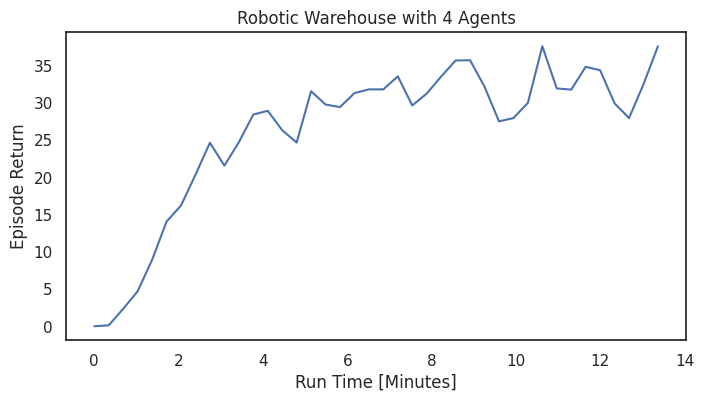

In [ ]:
# Run experiment for a total number of evaluations.
ep_returns = []
start_time = time.time()
n_devices = len(jax.devices())

for _ in range(config["arch"]["num_evaluation"]):
    # Train.
    learner_output = learn(learner_state)
    jax.block_until_ready(learner_output)

    # Prepare for evaluation.
    trained_params = unreplicate_batch_dim(learner_state.params.actor_params)

    key_e, *eval_keys = jax.random.split(key_e, n_devices + 1)
    eval_keys = jnp.stack(eval_keys)
    eval_keys = eval_keys.reshape(n_devices, -1)

    # Evaluate.
    evaluator_output = evaluator(trained_params, eval_keys, {})
    jax.block_until_ready(evaluator_output)

    mean_episode_return = jnp.mean(evaluator_output["episode_return"])
    ep_returns = plot_performance(mean_episode_return, ep_returns, start_time)

    # Update runner state to continue training.
    learner_state = learner_output.learner_state

# Return trained params to be used for rendering or testing.
trained_params = unreplicate_n_dims(trained_params, unreplicate_depth=1)

print(f"{Fore.CYAN}{Style.BRIGHT}MAPPO experiment completed{Style.RESET_ALL}")

#### Rendering

Now let's render one episode using the trained system

> Note: Creating a complete episode animation can be time-consuming. To address this, we offer a parameter named `max_steps` for the `render_one_episode` function. This parameter determines the number of states displayed in the GIF. Please note that a full episode usually consists of 500 steps.

In [ ]:
render_one_episode(config, trained_params)

In [ ]:
import os

from IPython.display import Image

if os.path.exists("/content/rware.gif"):
    display(Image(filename="/content/rware.gif"))
else:
    display(Image(filename="./rware.gif"))